# Catch Me If You Can (Alice)

**Introduction**

In this task, we solve a binary classification problem: 

- the goal is to determine whether a user belongs to the target group (in our case — whether the user is Alice) based on their internet session data.

Each session is represented as a sequence of visited websites, along with additional features such as session duration, start time, number of unique sites, activity during working hours, and more.

We aim to build a predictive model that estimates the probability of a user being Alice based on these session features.

**Objective**

The model should be able to rank users by their likelihood of belonging to the positive class (Alice). This is important in real-world scenarios where prioritizing users — for further analysis, verification, or personalization — is more useful than simply assigning binary labels.

**The evaluation metric**

We choose ROC-AUC (Area Under the Receiver Operating Characteristic Curve) as our primary evaluation metric because:

- It is threshold-independent, unlike accuracy or recall
- It works well even in cases of class imbalance
- It evaluates the model’s ability to rank positive instances higher than negative ones
- It enables fair comparison between models based on their overall discriminative power



**Data** 

I used the data from kaggle: https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/data

The train set *train_sessions.csv* contains information on user browsing sessions where the features are:

- site_i – are ids of sites in this session. The mapping is given with a pickled dictionary *site_dic.pkl*
- time_j – are timestamps of attending the corresponding site
- target – whether this session belongs to Alice

The task is to make predictions for the sessions in the test sample (*test_sessions.csv*) and determine if they belong to Alice.



In [1]:
# !lib

import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
sns.set_style() 

from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score 
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import shap


/Users/nadia/Documents/my_project/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PATH = '../data/raw/'

In [3]:
times = ['time%s' % i for i in range(1, 11)]
train_df = pd.read_csv(f'{PATH}train_sessions.csv',
                       index_col='session_id', parse_dates=times)
test_df = pd.read_csv(f'{PATH}test_sessions.csv', 
                      index_col='session_id', parse_dates=times)

In [4]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [5]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


In [6]:
with open(f'{PATH}site_dic.pkl', 'rb') as f:
    site_dic = pickle.load(f)

In [7]:
id2site = {v:k for (k, v) in site_dic.items()}
id2site[0] = 'unknown'

In [8]:
sites_dict =  pd.DataFrame({
    'id': list(id2site.keys()),
    'site': list(id2site.values())
})
print(u'Websites total:', sites_dict.shape[0])

Websites total: 48372


In [9]:
sites_dict

,id,site
0,25075,www.abmecatronique.com
1,13997,groups.live.com
2,42436,majeureliguefootball.wordpress.com
3,30911,cdt46.media.tourinsoft.eu
4,8104,www.hdwallpapers.eu
...,...,...
48367,40794,i1-js-14-3-01-12434-548464295-i.init.cedexis-r...
48368,10939,embed.api.tv
48369,40028,n-tennis.fr
48370,43410,posters.tripican.com


# EDA & Feature Engineering

In [10]:
(train_df.shape), (test_df.shape)

((253561, 21), (82797, 20))

In [11]:
train_df.isna().sum()

site1         0
time1         0
site2      3463
time2      3463
site3      6642
time3      6642
site4      9240
time4      9240
site5     11732
time5     11732
site6     14066
time6     14066
site7     16264
time7     16264
site8     18337
time8     18337
site9     20477
time9     20477
site10    22509
time10    22509
target        0
dtype: int64

In [12]:
test_df.isna().sum()

site1        0
time1        0
site2     1489
time2     1489
site3     2722
time3     2722
site4     3615
time4     3615
site5     4456
time5     4456
site6     5231
time6     5231
site7     5957
time7     5957
site8     6646
time8     6646
site9     7313
time9     7313
site10    7991
time10    7991
dtype: int64

In [13]:
# the samples are not balanced
train_df.groupby('target').count().iloc[:, 0] 

target
0    251264
1      2297
Name: site1, dtype: int64

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   site1   253561 non-null  int64         
 1   time1   253561 non-null  datetime64[ns]
 2   site2   250098 non-null  float64       
 3   time2   250098 non-null  datetime64[ns]
 4   site3   246919 non-null  float64       
 5   time3   246919 non-null  datetime64[ns]
 6   site4   244321 non-null  float64       
 7   time4   244321 non-null  datetime64[ns]
 8   site5   241829 non-null  float64       
 9   time5   241829 non-null  datetime64[ns]
 10  site6   239495 non-null  float64       
 11  time6   239495 non-null  datetime64[ns]
 12  site7   237297 non-null  float64       
 13  time7   237297 non-null  datetime64[ns]
 14  site8   235224 non-null  float64       
 15  time8   235224 non-null  datetime64[ns]
 16  site9   233084 non-null  float64       
 17  time9   233084 non-null  datetime6

In [15]:
times = [f'time{i}' for i in range(1, 11)]

for col in times:
    train_df[col] = pd.to_datetime(train_df[col], errors='coerce')
    test_df[col] = pd.to_datetime(test_df[col], errors='coerce')

In [16]:
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

In [17]:
def plot_percent_distributions(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    column: str,
    class_column: str = 'target',
    palette_source: dict = None,
    main_title: str = None,
    class_title: str = None,
    source_title: str = None,
    xlabel: str = "Category",
    sharey: bool = True
):
    """
    Plots two bar charts:
    1. Percentage distribution of the specified column within each class
    2. Comparison of percentage distributions between train and test sets for the same column

    Parameters:
        train_df -  Training dataset
        test_df  - Test dataset
        column -  Name of the column to analyze (e.g., 'day_of_week')
        class_column - Name of the target/class column (default is 'target')
        palette_source - Color palette for sources, e.g.,
        main_title - Main title for the entire figure
        class_title - Title for the first plot (by class)
        source_title - Title for the second plot (train vs test)
        xlabel - Label for the X-axis
        sharey - Whether to share the Y-axis across subplots
    """

    
    train_counts = (
        train_df
        .groupby([class_column, column])
        .size()
        .reset_index(name='count')
    )
    train_counts['percent'] = (
        train_counts.groupby(class_column)['count']
        .transform(lambda x: x / x.sum() * 100)
    )
    
    train_copy = train_df.copy()
    test_copy = test_df.copy()
    train_copy['source'] = 'train'
    test_copy['source'] = 'test'
    
    combined_df = pd.concat([train_copy, test_copy], ignore_index=True)
    
    source_counts = (
        combined_df
        .groupby(['source', column])
        .size()
        .reset_index(name='count')
    )
    source_counts['percent'] = (
        source_counts.groupby('source')['count']
        .transform(lambda x: x / x.sum() * 100)
    )
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=sharey)
    
    sns.barplot(
        data=train_counts,
        x=column,
        y='percent',
        hue=class_column,
        ax=axes[0]
    )
    axes[0].set_title(class_title or f"Train: % Distribution of {column} by {class_column}")
    axes[0].set_ylabel("Percentage within Class (%)")
    axes[0].set_xlabel(xlabel)
    
    sns.barplot(
        data=source_counts,
        x=column,
        y='percent',
        hue='source',
        palette=palette_source,
        ax=axes[1]
    )
    axes[1].set_title(source_title or f"Train vs Test: % Distribution of {column}")
    axes[1].set_ylabel("Percentage within Set (%)")
    axes[1].set_xlabel(xlabel)
    
    if main_title:
        plt.suptitle(main_title, fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
    else:
        plt.tight_layout()
    
    plt.show()

## Top Websites 

In [18]:
# Top websites in the training data set
top_sites = pd.Series(train_df[sites].values.flatten()
                     ).value_counts().sort_values(ascending=False).reset_index()
top_sites.columns = ['site_id', 'count']
top_sites['site_name'] = top_sites['site_id'].map(id2site)

In [19]:
top_10_sites = top_sites.head(10)
top_10_sites

,site_id,count,site_name
0,21,123776,www.google.fr
1,0,122730,unknown
2,23,87619,www.google.com
3,782,77055,annotathon.org
4,22,58258,apis.google.com
5,29,54094,www.facebook.com
6,167,46405,www.bing.com
7,780,43841,blast.ncbi.nlm.nih.gov
8,778,38194,www.ncbi.nlm.nih.gov
9,52,36085,clients1.google.com


In [20]:
# Top Alice's websites in the training data set
top_sites_alice = pd.Series(train_df[train_df['target']==1][sites].values.flatten()
                     ).value_counts().sort_values(ascending=False).reset_index()
top_sites_alice.columns = ['site_id', 'count']
top_sites_alice['site_name'] = top_sites_alice['site_id'].map(id2site)

top_10_sites_alice = top_sites_alice.head(10)
top_10_sites_alice

,site_id,count,site_name
0,77,1382,i1.ytimg.com
1,80,1354,s.youtube.com
2,76,1307,www.youtube.com
3,29,897,www.facebook.com
4,21,857,www.google.fr
5,81,609,r4---sn-gxo5uxg-jqbe.googlevideo.com
6,22,522,apis.google.com
7,879,522,r1---sn-gxo5uxg-jqbe.googlevideo.com
8,75,451,s.ytimg.com
9,82,447,r2---sn-gxo5uxg-jqbe.googlevideo.com


In [21]:
top_10_sites

,site_id,count,site_name
0,21,123776,www.google.fr
1,0,122730,unknown
2,23,87619,www.google.com
3,782,77055,annotathon.org
4,22,58258,apis.google.com
5,29,54094,www.facebook.com
6,167,46405,www.bing.com
7,780,43841,blast.ncbi.nlm.nih.gov
8,778,38194,www.ncbi.nlm.nih.gov
9,52,36085,clients1.google.com


In [22]:
train_df['has_top_10'] = train_df[sites].map(lambda x: int(x in set(top_10_sites['site_id']))).any(axis=1).astype(int)
train_df['has_top_10_Alice'] = train_df[sites].map(lambda x: int(x in set(top_10_sites_alice['site_id']))).any(axis=1).astype(int)

In [23]:
test_df['has_top_10'] = test_df[sites].map(lambda x: int(x in set(top_10_sites['site_id']))).any(axis=1).astype(int)
test_df['has_top_10_Alice'] = test_df[sites].map(lambda x: int(x in set(top_10_sites_alice['site_id']))).any(axis=1).astype(int)

In [24]:
group_counts_top_10 = train_df.groupby(['target', 'has_top_10']).size()
group_counts_top_10 / group_counts_top_10.groupby(level=0).sum()

target  has_top_10
0       0             0.298638
        1             0.701362
1       0             0.405747
        1             0.594253
dtype: float64

In [25]:
group_counts_top_10_Alice = train_df.groupby(['target', 'has_top_10_Alice']).size()
group_counts_top_10_Alice / group_counts_top_10_Alice.groupby(level=0).sum()

target  has_top_10_Alice
0       0                   0.507617
        1                   0.492383
1       0                   0.255986
        1                   0.744014
dtype: float64

You can see the difference between popular Alice and non-Alice sites.
Alice is less focused on popular resources than other users — this may be a behavioral feature.

In [26]:
top_10_set = set(top_10_sites['site_id'])
top_10_Alice_set = set(top_10_sites_alice['site_id'])

train_df['top_10_count'] = train_df[sites].map(lambda x: int(x in top_10_set)).sum(axis=1)
train_df['top_10_Alice_count'] = train_df[sites].map(lambda x: int(x in top_10_Alice_set)).sum(axis=1)

In [27]:
test_df['top_10_count'] = test_df[sites].map(lambda x: int(x in top_10_set)).sum(axis=1)
test_df['top_10_Alice_count'] = test_df[sites].map(lambda x: int(x in top_10_Alice_set)).sum(axis=1)

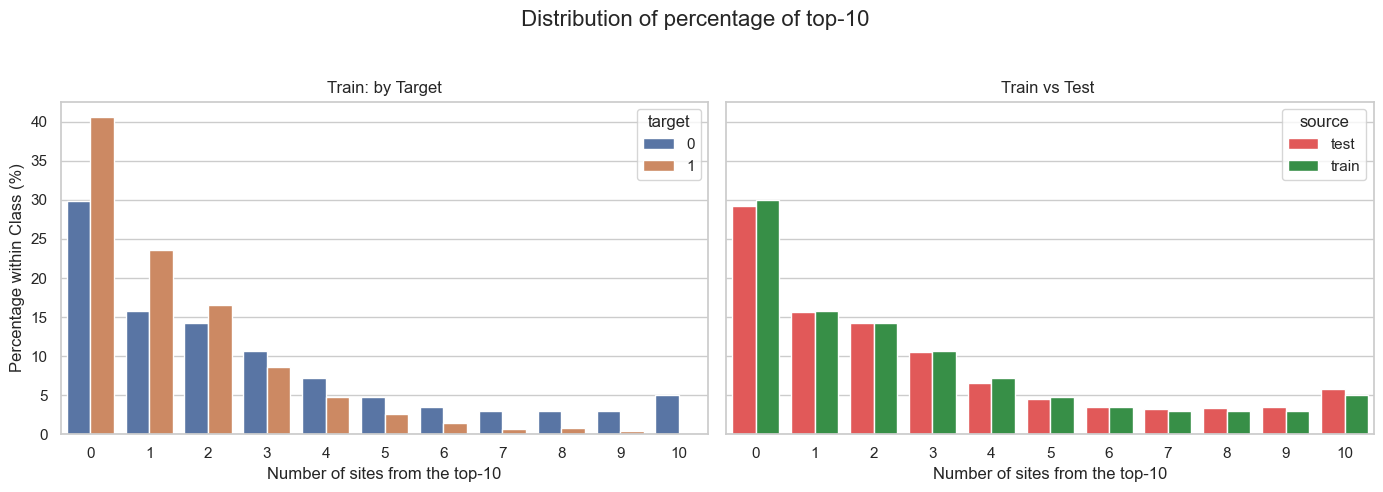

In [28]:
plot_percent_distributions(
    train_df=train_df,
    test_df=test_df,
    column='top_10_count',
    palette_source={'train': '#289e3d', 'test': '#f74343'},
    main_title=" Distribution of percentage of top-10",
    class_title="Train: by Target",
    source_title="Train vs Test ",
    xlabel="Number of sites from the top-10"
)

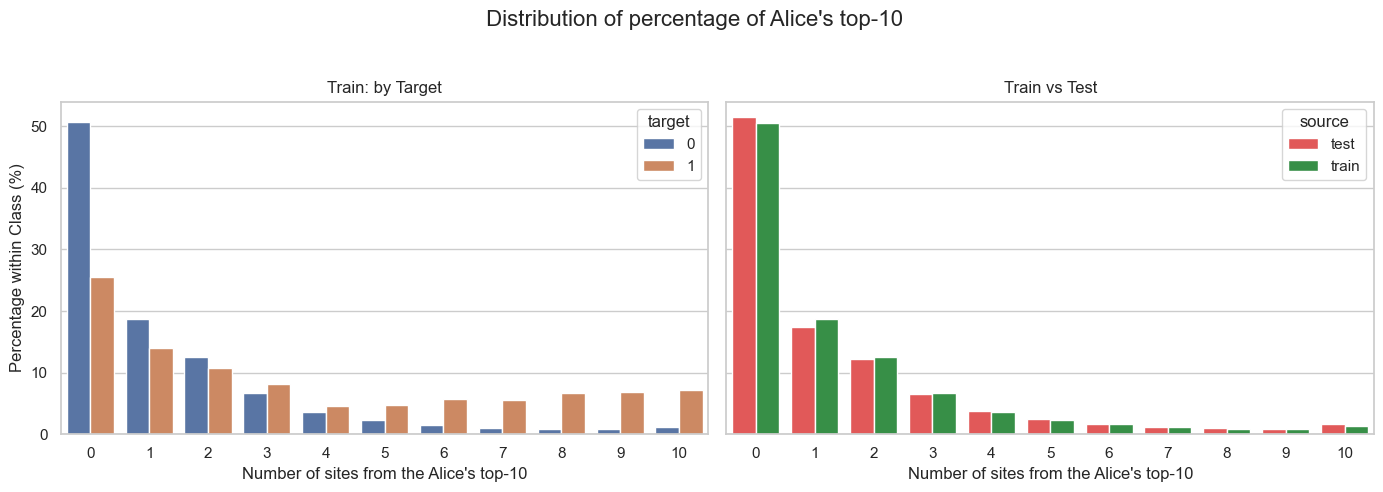

In [29]:
plot_percent_distributions(
    train_df=train_df,
    test_df=test_df,
    column='top_10_Alice_count',
    palette_source={'train': '#289e3d', 'test': '#f74343'},
    main_title=" Distribution of percentage of Alice's top-10",
    class_title="Train: by Target",
    source_title="Train vs Test",
    xlabel="Number of sites from the Alice's top-10"
)

- The same pattern can be seen in the number of popular sites per session for the target group. The "number of sites from Alice's top-10" attribute separates the classes well — it is especially useful in the range from 3 to 10.
- Class 1 is more "active" in using top sites — this behavior can be used for modeling.
- The distributions in train and test are quite consistent, you can use the feature without fear.


### Number of sites per session

In [30]:
train_df['session_steps']=train_df[sites].apply(lambda x : x[x != 0].count(), axis=1)
test_df['session_steps']=test_df[sites].apply(lambda x : x[x != 0].count(), axis=1)

In [31]:
train_df['uniq_sites']=train_df[sites].apply(lambda x : x[x != 0].nunique(), axis=1)
test_df['uniq_sites']=test_df[sites].apply(lambda x : x[x != 0].nunique(), axis=1)

In [32]:
train_df[train_df['session_steps']==1].groupby('target').count().iloc[:, 0]

target
0    3460
1       3
Name: site1, dtype: int64

In [33]:
# average percentage of sessions with one step
train_df[train_df['session_steps']==1].groupby('target').count().iloc[:, 0]/train_df.groupby('target').count().iloc[:, 0]*100

target
0    1.377038
1    0.130605
Name: site1, dtype: float64

In [34]:
# average percentage of sessions with 10 steps
train_df[train_df['session_steps']<10].groupby('target').count().iloc[:, 0]/train_df.groupby('target').count().iloc[:, 0]*100

target
0    8.942785
1    1.697867
Name: site1, dtype: float64

In [35]:
train_df.groupby('target')['session_steps'].describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,251264.0,9.512350,1.742295,1.0,10.0,10.0,10.0,10.0
1,2297.0,9.912495,0.734720,1.0,10.0,10.0,10.0,10.0


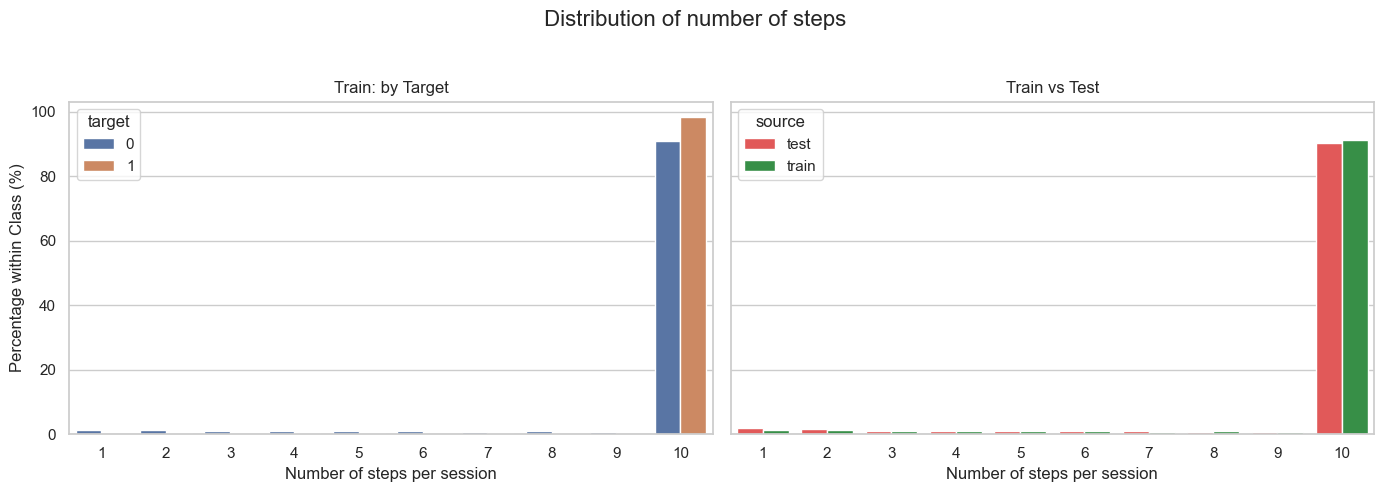

In [36]:
plot_percent_distributions(
    train_df=train_df,
    test_df=test_df,
    column='session_steps',
    palette_source={'train': '#289e3d', 'test': '#f74343'},
    main_title=" Distribution of number of steps",
    class_title="Train: by Target",
    source_title="Train vs Test",
    xlabel="Number of steps per session"
)

Classes are unbalanced. Alice usually visits more websites than 'not-Alice' per session

Lets create one more feature - the percentage of sites visited from Alice's top 10

In [37]:
train_df['top_alices_sites_share'] = train_df['top_10_Alice_count']/train_df['session_steps']
test_df['top_alices_sites_share'] = test_df['top_10_Alice_count']/test_df['session_steps']

### Number of unique sites per session

In [38]:
train_df.groupby('target')['uniq_sites'].describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,251264.0,5.634086,2.499787,1.0,4.0,6.0,8.0,10.0
1,2297.0,6.109273,2.010379,1.0,5.0,6.0,8.0,10.0


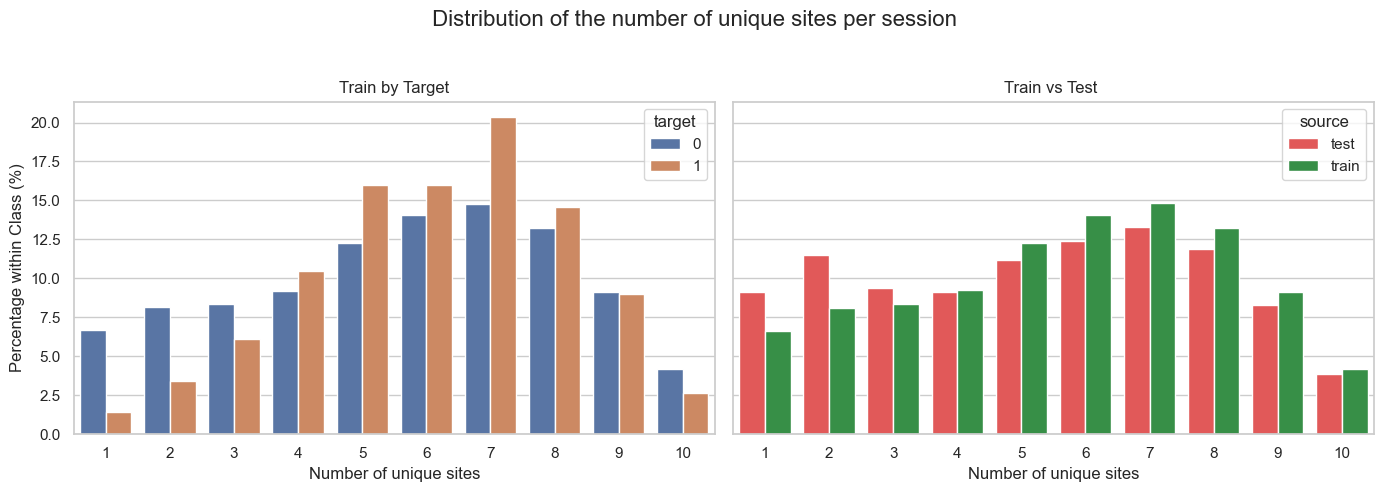

In [39]:
plot_percent_distributions(
    train_df=train_df,
    test_df=test_df,
    column='uniq_sites',
    palette_source={'train': '#289e3d', 'test': '#f74343'},
    main_title=" Distribution of the number of unique sites per session",
    class_title="Train by Target",
    source_title="Train vs Test ",
    xlabel="Number of unique sites"
)

### Duration of sessions

In [40]:
train_df['min_time']=train_df[times].min(axis=1)
train_df['max_time']=train_df[times].max(axis=1)
train_df['session_duration'] = (train_df['max_time'] - train_df['min_time']) / np.timedelta64(1, 's')

In [41]:
test_df['min_time']=test_df[times].min(axis=1)
test_df['max_time']=test_df[times].max(axis=1)

test_df['session_duration'] = (test_df['max_time'] - test_df['min_time']) / np.timedelta64(1, 's')

In [42]:
# check that the data is sorted correctly 
train_df[(train_df['min_time']==train_df['time1'])==False]

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,has_top_10,has_top_10_Alice,top_10_count,top_10_Alice_count,session_steps,uniq_sites,top_alices_sites_share,min_time,max_time,session_duration
session_id,,,,,,,,,,,,,,,,,,,,,


In [43]:
test_df[(test_df['min_time']==test_df['time1'])==False]

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,has_top_10,has_top_10_Alice,top_10_count,top_10_Alice_count,session_steps,uniq_sites,top_alices_sites_share,min_time,max_time,session_duration
session_id,,,,,,,,,,,,,,,,,,,,,


In [44]:
train_df.groupby('target')['session_duration'].describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,251264.0,139.282372,296.653518,0.0,7.0,28.0,114.0,1800.0
1,2297.0,52.296474,153.309014,0.0,4.0,11.0,38.0,1763.0


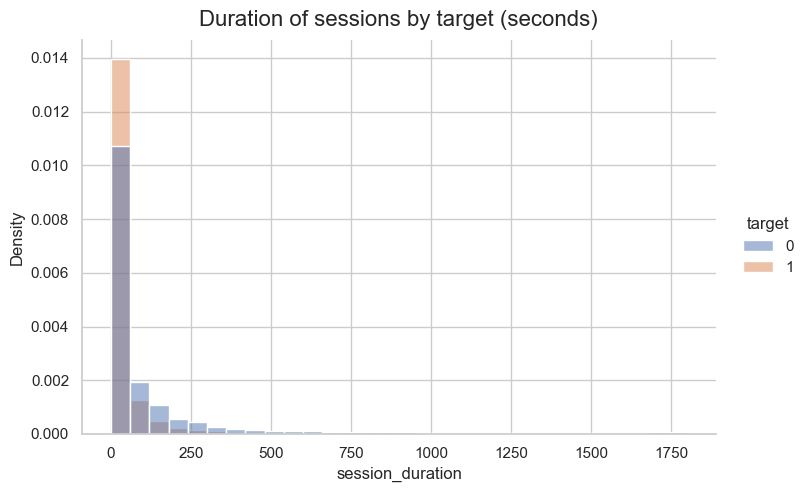

In [45]:
fig = sns.displot(
    data=train_df, 
    x='session_duration', 
    hue='target',
    stat='density', 
    common_norm=False,
    bins=30,
    aspect=1.5
)

fig.fig.suptitle('Duration of sessions by target (seconds)', fontsize=16)
fig.fig.subplots_adjust(top=0.92)  

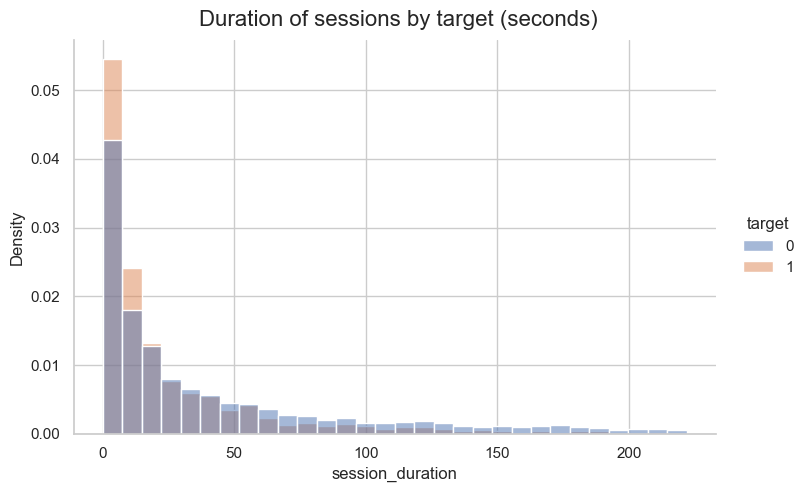

In [46]:
fig = sns.displot(
    data=train_df[train_df['session_duration']<np.percentile(train_df['session_duration'],85)], 
    x='session_duration', 
    hue='target',
    stat='density', 
    common_norm=False,
    bins=30,
    aspect=1.5
)

fig.fig.suptitle('Duration of sessions by target (seconds)', fontsize=16)
fig.fig.subplots_adjust(top=0.92)  

Alice's sessions're shorter than non-Alices

### Session start by hour

In [47]:
train_df['start_hour'] = train_df['min_time'].apply(lambda x: x.hour)
test_df['start_hour'] = test_df['min_time'].apply(lambda x: x.hour)

In [48]:
train_df.groupby('target')['start_hour'].describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,251264.0,12.259731,3.153245,7.0,10.0,12.0,14.0,23.0
1,2297.0,15.433609,2.065365,9.0,13.0,16.0,17.0,18.0


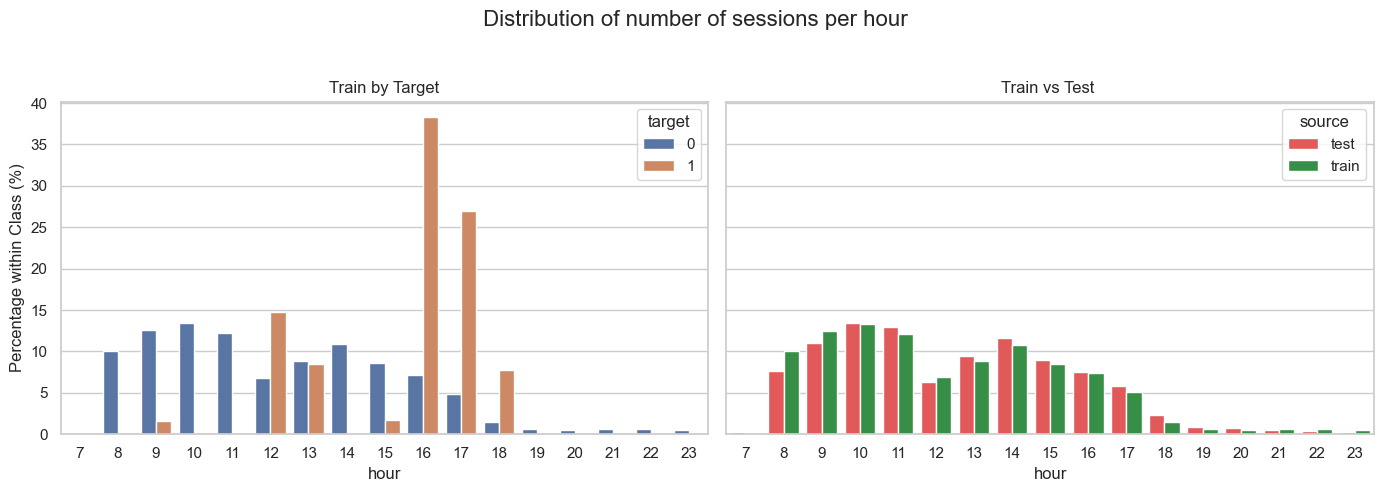

In [49]:
plot_percent_distributions(
    train_df=train_df,
    test_df=test_df,
    column='start_hour',
    palette_source={'train': '#289e3d', 'test': '#f74343'},
    main_title=" Distribution of number of sessions per hour",
    class_title="Train by Target",
    source_title="Train vs Test ",
    xlabel="hour"
)

We can see that the distribution of Alice's starting hours has two peaks at 12:00 and 16:00. The distribution for target = 0 is left-skewed, with two less pronounced peaks, and is more spread out overall. Also Alice is offline during evenening hours 

In [50]:
train_df['working_hours']=train_df['start_hour'].apply(lambda x: 1 if 9<=x<=18 else 0)
test_df['working_hours']=test_df['start_hour'].apply(lambda x: 1 if 9<=x<=18 else 0)

In [51]:
train_df.groupby('target')['working_hours'].value_counts(normalize=True) * 100

target  working_hours
0       1                 86.881925
        0                 13.118075
1       1                100.000000
Name: proportion, dtype: float64

Moreover, Alice visits websites only in working hours 

Lets add  cyclic coordinates to reduce complexity for the model  

In [52]:
pi = np.pi
train_df['hour_sin_x'] = train_df['start_hour'].apply(lambda x: np.sin(2*pi*x/24))
train_df['hour_cos_x'] = train_df['start_hour'].apply(lambda x: np.cos(2*pi*x/24))

test_df['hour_sin_x'] = test_df['start_hour'].apply(lambda x: np.sin(2*pi*x/24))
test_df['hour_cos_x'] = test_df['start_hour'].apply(lambda x: np.cos(2*pi*x/24))

### Session start by weekday 

In [53]:
train_df['day_of_week'] = train_df['min_time'].apply(lambda x: x.dayofweek)
test_df['day_of_week'] = test_df['min_time'].apply(lambda x: x.dayofweek)

In [54]:
train_df['is_weekend'] = train_df['day_of_week'].apply(lambda x: 1 if x in (5,6) else 0)
test_df['is_weekend'] = test_df['day_of_week'].apply(lambda x: 1 if x in (5,6) else 0)

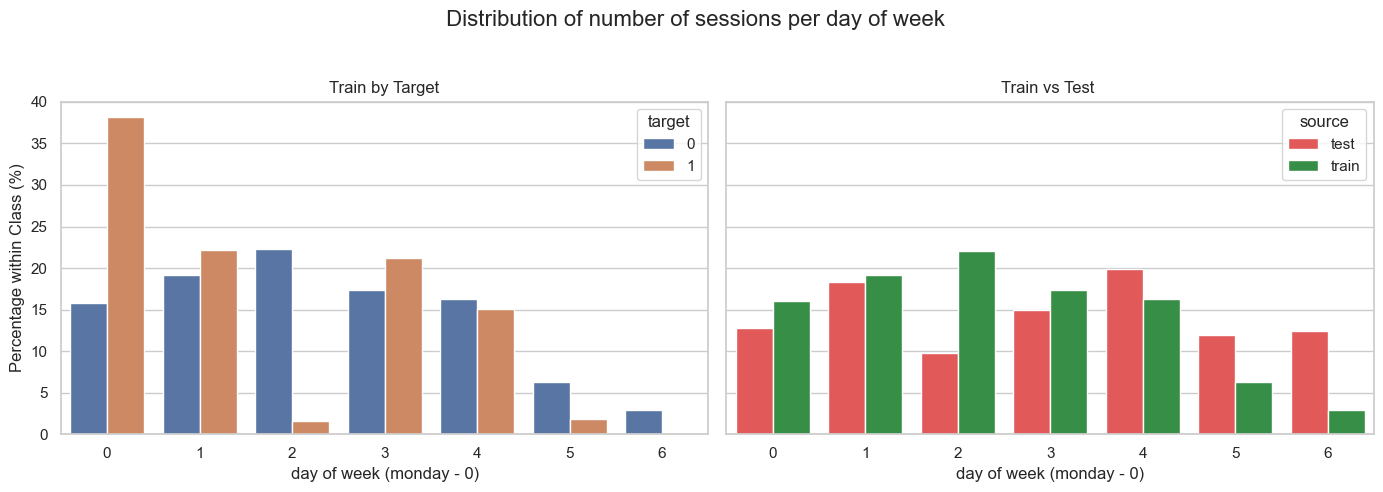

In [55]:
plot_percent_distributions(
    train_df=train_df,
    test_df=test_df,
    column='day_of_week',
    palette_source={'train': '#289e3d', 'test': '#f74343'},
    main_title=" Distribution of number of sessions per day of week",
    class_title="Train by Target",
    source_title="Train vs Test ",
    xlabel="day of week (monday - 0)"
)

It can be seen that Alice visits websites mostly on Mondays, rarely uses the Internet on Wednesdays and Saturdays and doesn't use it on Sundays. 

### Session start by month

In [56]:
train_df['month'] = train_df['min_time'].apply(lambda x: x.month)
test_df['month'] = test_df['min_time'].apply(lambda x: x.month)

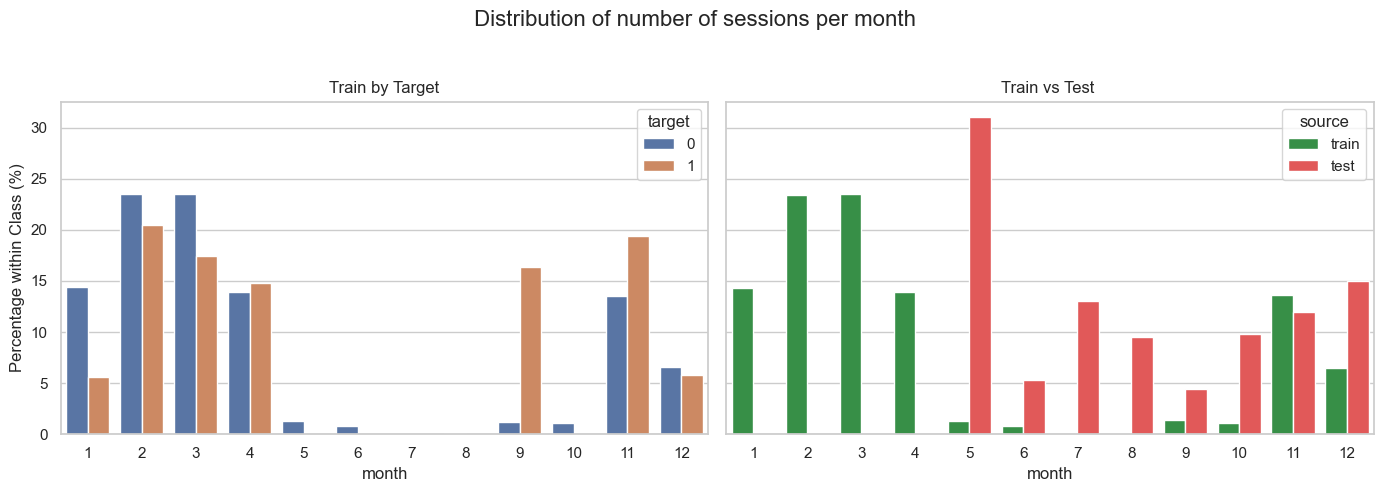

In [57]:
plot_percent_distributions(
    train_df=train_df,
    test_df=test_df,
    column='month',
    palette_source={'train': '#289e3d', 'test': '#f74343'},
    main_title=" Distribution of number of sessions per month",
    class_title="Train by Target",
    source_title="Train vs Test ",
    xlabel="month"
)

In [58]:
train_df['day'] = train_df['min_time'].apply(lambda x: x.day)
test_df['day'] = test_df['min_time'].apply(lambda x: x.day)

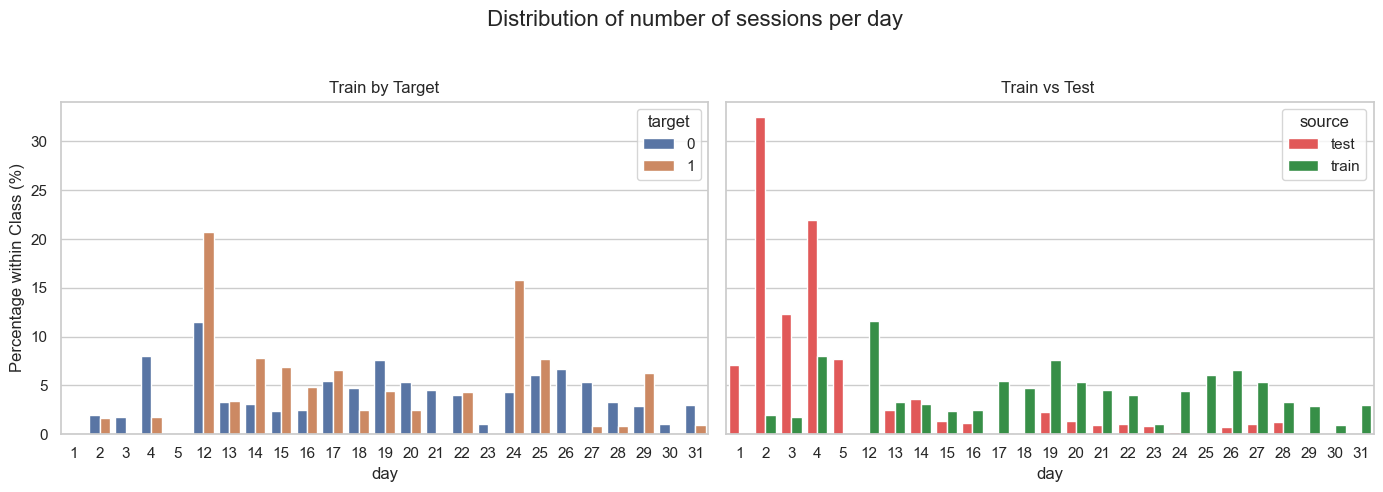

In [59]:
plot_percent_distributions(
    train_df=train_df,
    test_df=test_df,
    column='day',
    palette_source={'train': '#289e3d', 'test': '#f74343'},
    main_title=" Distribution of number of sessions per day",
    class_title="Train by Target",
    source_title="Train vs Test ",
    xlabel="day"
)

We can see that Alice is inactive from May to August.

The distribution in the test and train samples is heterogeneous, and there is a high probability of overfitting the model. It is necessary to check the importance of the feature further on the cross-validation

# Training the Model (Logistic Regression)

There is an idea that we can use only one feature for modeling - the sequence of sites visited. Let's use this feature for the first basic model. 

We're using CountVectorizer because  punctuation and other symbols are not so important in our task

## Basic Model 

In [60]:
sites = ['site%s' % i for i in range(1, 11)]
train_sessions = train_df[sites].apply(lambda row: ' '.join([id2site[i] for i in row]), axis=1).tolist()
test_sessions = test_df[sites].apply(lambda row: ' '.join([id2site[i] for i in row]), axis=1).tolist()

In [61]:
# Keeping the time order
split_index = int(len(train_sessions) * 0.8)

train_sessions_text = train_sessions[:split_index]
valid_sessions_text = train_sessions[split_index:]

y_train = train_df['target'].iloc[:split_index]
y_valid = train_df['target'].iloc[split_index:]

In [62]:
cv = CountVectorizer(ngram_range=(1, 3), max_features=50000)

In [63]:
X_train = cv.fit_transform(train_sessions_text)
X_valid = cv.transform(valid_sessions_text)
X_test = cv.transform(test_sessions)

In [64]:
tscv = TimeSeriesSplit(n_splits=5)
logit = LogisticRegression(C=1, random_state=17, solver='liblinear')

In [65]:
scores = cross_val_score(logit, X_train, y_train, cv=tscv, scoring='roc_auc')
print(f"ROC-AUC on CV: {scores.mean():.4f} ± {scores.std():.4f}")

ROC-AUC on CV: 0.9442 ± 0.0111


In [66]:
logit.fit(X_train, y_train)
y_valid_pred = logit.predict_proba(X_valid)[:, 1]
roc_auc_predict = roc_auc_score(y_valid, y_valid_pred)
print(f"ROC-AUC on validation: {roc_auc_predict:.4f}")

ROC-AUC on validation: 0.9592


## Adding extra features 

In [67]:
extra_features = [
    'has_top_10', 'has_top_10_Alice', 'top_10_count', 'top_10_Alice_count',
    'session_steps', 'uniq_sites', 'top_alices_sites_share', 'session_duration', 'start_hour', 'working_hours',
    'hour_sin_x', 'hour_cos_x', 'day_of_week', 'is_weekend', 'month', 'day'
                 ]

In [68]:
train_features = train_df.loc[y_train.index, extra_features]
valid_features = train_df.loc[y_valid.index, extra_features]

X_train_full = hstack([X_train, train_features])
X_valid_full = hstack([X_valid, valid_features])

In [69]:
scores = cross_val_score(logit, X_train_full, y_train, cv=tscv, scoring='roc_auc')
print(f"ROC AUC with extra features: {scores.mean():.4f} ± {scores.std():.4f}")

ROC AUC with extra features: 0.9679 ± 0.0070


In [70]:
logit.fit(X_train_full, y_train)
y_valid_pred = logit.predict_proba(X_valid_full)[:, 1]

roc_auc = roc_auc_score(y_valid, y_valid_pred)
print(f"ROC AUC on validation (extra features): {roc_auc:.4f}")

ROC AUC on validation (extra features): 0.9776


In [71]:
# for feature in extra_features:
#     X_tmp = hstack([X_train, train_df[[feature]]])
#     score = cross_val_score(logit, X_tmp, target, cv=tscv, scoring='roc_auc').mean()
#     print(f'{feature:<25} → ROC AUC: {score:.4f}')

## Removing a few extra features 

Let's check the multicollinearity metric: it shows how much one feature linearly depends on the others.

In [72]:
X_num = train_df[extra_features].dropna().astype(float) 
X_const = add_constant(X_num)

vif_data = pd.DataFrame()
vif_data["feature"] = X_num.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i+1) for i in range(X_num.shape[1])]
print(vif_data)

                   feature        VIF
0               has_top_10   2.880953
1         has_top_10_Alice   3.311292
2             top_10_count   2.604961
3       top_10_Alice_count  26.482470
4            session_steps   1.528937
5               uniq_sites   1.658973
6   top_alices_sites_share  27.494387
7         session_duration   1.027896
8               start_hour  22.453506
9            working_hours   2.503080
10              hour_sin_x  16.520191
11              hour_cos_x   4.868529
12             day_of_week   1.574046
13              is_weekend   1.634868
14                   month   1.023408
15                     day   1.045199


In [73]:
# drop top_10_Alice_count and start_hour
extra_features_new = [
    'has_top_10', 'has_top_10_Alice', 'top_10_count', 
    'session_steps', 'uniq_sites', 'top_alices_sites_share', 
    'session_duration', 'working_hours','hour_sin_x', 
    'hour_cos_x', 'day_of_week', 'is_weekend', 'month', 'day'
                    ]

In [74]:
train_features_new = train_df.loc[y_train.index, extra_features_new]
valid_features_new = train_df.loc[y_valid.index, extra_features_new]

X_train_full_new = hstack([X_train, train_features_new])
X_valid_full_new = hstack([X_valid, valid_features_new])

In [75]:
scores = cross_val_score(logit, X_train_full_new, y_train, cv=tscv, scoring='roc_auc')
print(f"ROC AUC with extra features (2): {scores.mean():.4f} ± {scores.std():.4f}")

ROC AUC with extra features (2): 0.9677 ± 0.0069


In [76]:
logit.fit(X_train_full_new, y_train)
y_valid_pred = logit.predict_proba(X_valid_full_new)[:, 1]

roc_auc = roc_auc_score(y_valid, y_valid_pred)
print(f"ROC AUC on validation (extra features)(2): {roc_auc:.4f}")

ROC AUC on validation (extra features)(2): 0.9775


## Features Contribution 

Let's see what contribution the features make.

In [77]:
logit.fit(X_train_full_new, y_train)
coefs = logit.coef_[0]

feature_names = cv.get_feature_names_out().tolist() + extra_features_new

top_ids = np.argsort(np.abs(coefs))[::-1][:20]

for i in top_ids:
    weight = coefs[i]
    color = "\033[92m" if weight > 0 else "\033[91m"  
    reset = "\033[0m"
    print(f"{feature_names[i]:<30} {color}{weight:+.4f}{reset}")


working_hours                  +3.8705
hour_sin_x                     -2.4525
agora                          +1.9200
live com platform              +1.9036
youtube fr                     +1.8292
ocsp                           -1.7992
tru                            +1.7651
tru am                         +1.7651
ta                             +1.7326
bing com api                   -1.6075
tynt com twitter               +1.5800
google com vk                  +1.5520
glee                           +1.4388
magasins                       +1.4339
fr www info                    +1.4081
exashare com                   +1.3981
exashare                       +1.3981
ed6c3e6a5c6608a4 users storage +1.3828
ed6c3e6a5c6608a4 users         +1.3828
ed6c3e6a5c6608a4               +1.3828


In [78]:
n_text_features = len(cv.get_feature_names_out()) 
text_coef = coefs[:n_text_features]
extra_coef = coefs[n_text_features:]

text_importance = np.sum(np.abs(text_coef))

print(f"Contribution of text features (in total): {text_importance:.4f}")
extra = list(zip(extra_features_new, extra_coef))
extra_sorted = sorted(extra, key=lambda x: abs(x[1]), reverse=True)

for name, weight in extra_sorted:
    color = "\033[92m" if weight > 0 else "\033[91m" 
    reset = "\033[0m"
    print(f"{name:<30} {color}{weight:+.4f}{reset}")

Contribution of text features (in total): 2683.0401
working_hours                  +3.8705
hour_sin_x                     -2.4525
session_steps                  -1.1980
hour_cos_x                     +0.9200
is_weekend                     -0.8332
has_top_10                     +0.3523
day_of_week                    -0.3063
uniq_sites                     +0.2176
month                          +0.1981
top_alices_sites_share         -0.1681
top_10_count                   -0.0858
has_top_10_Alice               +0.0763
day                            -0.0398
session_duration               -0.0006


In [79]:
explainer = shap.Explainer(logit, valid_features_new)
shap_values = explainer(valid_features_new)
shap.summary_plot(shap_values, feature_names=extra_features_new)

ValueError: shapes (50014,) and (14,) not aligned: 50014 (dim 0) != 14 (dim 0)

If the model is studied only by the created features, then in this case we can see that the sequence of visited sites makes the greatest contribution.

In [ ]:

logit.fit(train_features_new, y_train)
y_valid_pred = logit.predict_proba(valid_features_new)[:, 1] 
roc_auc = roc_auc_score(y_valid, y_valid_pred)
print(f"ROC AUC on validation (extra features only): {roc_auc:.4f}")

ROC AUC on validation (extra features only): 0.8662


## Different Regularization Strengt (C)

Let's leave the model with fewer features, removing the collinear ones and those that do not make a big contribution. Thus, we will simplify the model without losing its quality.

Now let's check the logistic regression with different regularization strengt **C** 

In [ ]:
C_values = [0.01, 0.1, 0.3, 1, 3, 10]
results = []

for C in C_values:
    model = LogisticRegression(C=C, random_state=17, solver='liblinear')
    scores = cross_val_score(model, X_train_full_new, y_train, cv=tscv, scoring='roc_auc')
    mean_score = scores.mean()
    std_score = scores.std()
    results.append((C, mean_score, std_score))
    print(f"C={C:<5} ROC AUC: {mean_score:.4f} ± {std_score:.4f}")

C=0.01  ROC AUC: 0.9523 ± 0.0135
C=0.1   ROC AUC: 0.9670 ± 0.0086


KeyboardInterrupt: 

- The model is insensitive to the choice of C in the range [0.1 – 10].

- This is excellent, which means that the signs are well prepared and the regularization is stable.

- Let's leave C=1

## Random Forest 

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=17, n_jobs=-1)

rf.fit(X_train_full_new, y_train)
y_valid_pred_rf = rf.predict_proba(X_valid_full_new)[:, 1]

roc_auc_rf = roc_auc_score(y_valid, y_valid_pred_rf)
print(f"ROC AUC on validation (Random Forest): {roc_auc_rf:.4f}")

ROC AUC on validation (Random Forest): 0.9683


In [ ]:
rf.fit(train_features_new, y_train)
y_valid_pred_rf = rf.predict_proba(valid_features_new)[:, 1]

roc_auc_rf = roc_auc_score(y_valid, y_valid_pred_rf)
print(f"ROC AUC on validation (Random Forest) - created features only: {roc_auc_rf:.4f}")

ROC AUC on validation (Random Forest) - created features only: 0.9717


Why Logistic Regression Performs Better in This Task: 

The use of CountVectorizer generates a high-dimensional sparse matrix, often with tens of thousands of features, where most values are zeros.

Logistic Regression performs well in this setting because:

- It is a linear model, well-suited for sparse and high-dimensional feature spaces.

- It does not require deep interactions between features to capture useful patterns.

- It can effectively combine many weak signals across sparse inputs.

In contrast, Random Forest struggles with this type of data:

- Each tree split considers only a single feature, making it sensitive to noisy or weakly informative features.

- Decision trees are generally inefficient on high-dimensional sparse data, especially when meaningful information is spread thinly across many features.

Therefore, Logistic Regression outperforms Random Forest in this task — not because it is inherently more powerful, but because it is better aligned with the structure of the input data.

When we remove the sparse matrix and use only the hand-crafted numerical features, we observe a slight improvement in ROC AUC for Random Forest.




**The best result:**

Logistic regression (C=1): sparce matrix + a selected set of created features, ROC-AUC on validation data = 0.9775
